# Hamiltonian Neural Network - Hénon-Heiles System

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns
from Systems.HenonHeiles import *
from Systems.Generate_Data import *
from HamiltonianNeuralNetwork.HNN import *
from HamiltonianNeuralNetwork.Train import *
from NumericalIntegration.Numerical_Integration import *

torch.random.manual_seed(1)
np.random.seed(33)

plt.rcParams['font.size'] = 12
plt.rcParams['lines.markersize'] = 10
plt.rcParams['legend.fontsize'] = 10
colors = sns.color_palette([(0.6,0.8,.8), (1,0.7,0.3), (0.2,0.7,0.2), (0.8,0,0.2), (0,0.4,1), (0.6,0.5,.9), (0.5,0.3,.5)])

In [2]:
def initial_condition(lam = 1):
    def sampler():
            """Function for sampling initial conditions. Callabale taking
                a numpy random generator as input and returning an ndarray
                of shape (nstates,) with inital conditions for the system."""
        
            x0= 0
            H0 = np.random.uniform(0,1/10)
            while True:
                y0 = np.random.uniform(-1,1)    
                py0 = np.random.uniform(-1,1)
                K = 2*H0-(py0**2 +y0**2-lam/3*y0**3)
                if K>= 0:
                    break
            px0 = np.sqrt(K)

            return np.array([x0,y0,px0,py0]).flatten()
    return sampler()

In [3]:
T_max_train = 5
nsamples_train = 100
ntraj_train = 1750
T_max_val = T_max_train
nsamples_val = nsamples_train
ntraj_val = 750
epochs = 50

#Activations nn.Tanh(), nn.ReLU(), Sin(), nn.Softplus(), PAU(), PadeTypeActivation

act_1 = nn.Tanh()
act_2 = nn.ReLU()

lr = 1e-3
batch_size = 64
sys = HenonHeilesSystem()

dt_train = T_max_train/nsamples_train
nt_train = round(T_max_train / dt_train)
t_train = np.linspace(0, T_max_train, nt_train + 1)

dt_val = T_max_val/nsamples_val
nt_val = round(T_max_val / dt_val)
t_val= np.linspace(0, T_max_val, nt_val + 1)

In [4]:
def HenonHeiles_loss_func(dudt,dudt_est):
    func = torch.nn.MSELoss()
    MSE_dudt = func(dudt_est,dudt)
    return MSE_dudt

loss_func = loss_wrapper(HenonHeiles_loss_func)

## Explicit Midpoint

100%|██████████| 10/10 [00:03<00:00,  3.20it/s, epoch=9, loss=0.00209]


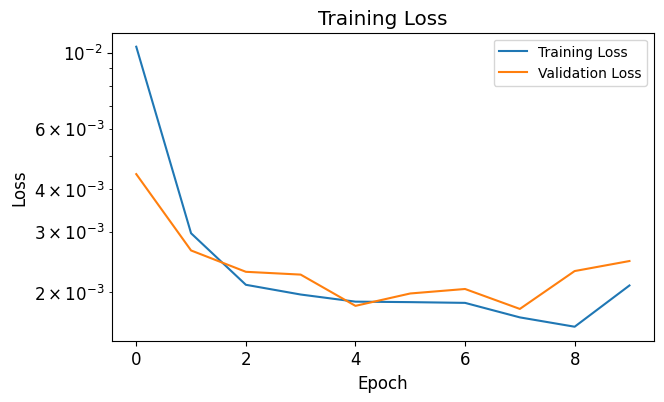

In [12]:
integrator = "midpoint"

(u_start, u_end,_, dt), dudt, u_train, u0s_train  =  generate_data(system=sys,ntrajectories =ntraj_train, t_sample = t_train,integrator=integrator)
train_data = (u_start, u_end, dt), dudt

(u_start, u_end,_, dt), dudt, u_val, u0s_val =  generate_data(system=sys,ntrajectories =ntraj_val, t_sample = t_val,integrator=integrator)
val_data = (u_start, u_end, dt), dudt

model_exp = HamiltonianNeuralNetwork(nstates = sys.nstates, S=sys.S, sys = sys, Hamiltonian_estimated = BaseHamiltonianNeuralNetwork(nstates=sys.nstates, act_1 = act_1, act_2 = act_2), initial_condition_sampler = initial_condition)

optimizer_exp = torch.optim.Adam(model_exp.parameters(), lr=lr)

trainer = Training(model = model_exp,integrator = integrator, train_data = train_data, val_data = val_data,optimizer = optimizer_exp, system = sys, batch_size=batch_size,epochs = epochs)
model_exp, trainingdetails_explicit = trainer.train(loss_func)

### Predicting from Explicit Midpoint

In [5]:
model_exp,_,_ = load_model(path= "Models/HenonHeiles/HenonHeiles_midpoint_50epoch_PAU()_Softplus(beta=1.0, threshold=20.0)_batchsize_64_shape_torch.Size([175000, 4]).pt")

In [6]:
tmax = 5*10
nsamples = 100*10
dt = tmax/nsamples

nt = round(tmax / dt)
t_sample = np.linspace(0, tmax, nt + 1)
integrator = "midpoint"
ntrajectories = 1

(u_start, u_end,_, dt), dudt, u_exact, u0s =  generate_data(system=sys,ntrajectories =ntrajectories, t_sample = t_sample,integrator=integrator)

u_phnn_exp, t_sample = model_exp.generate_trajectories(ntrajectories = ntrajectories, t_sample = t_sample,integrator = integrator,u0s=u0s)


100%|██████████| 1/1 [00:00<00:00, 107.03it/s]
/Users/sannejamila/Documents/Vår 2025/Prosjektoppgave/Oppgave_github/HNNs_ODEs/HamiltonianNeuralNetwork/HNN.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u0 = torch.tensor(u0,dtype = torch.float32)


In [7]:
def get_Hamiltonians(model,u_exact,u_pred,t_sample):
    H_exact = torch.tensor([sys.Hamiltonian(u) for u in u_exact.squeeze(0)])

    t = t_sample.squeeze(0)
    u_samples = u_pred.squeeze(0)
    #Computed estimated Hamiltonian from values for prediction
    H_nn= torch.tensor([(model.Hamiltonian(u)- model.Hamiltonian(torch.tensor([[0.,  0.,  0.,  0.]])) )for u in u_samples])
    #Computed true Hamiltonian values for prediction
    H_exact_pred = torch.tensor([sys.Hamiltonian(u) for u in u_samples])
    #Computed NN Hamiltonian for exact
    H_nn_exact = torch.tensor([(model.Hamiltonian(torch.tensor(u, dtype = torch.float32)) - model.Hamiltonian(torch.tensor([[0., 0., 0., 0.]]))) for u in u_exact.squeeze(0)])


    return H_exact, H_nn, H_exact_pred, H_nn_exact

/Users/sannejamila/Documents/Vår 2025/Prosjektoppgave/Oppgave_github/HNNs_ODEs/Systems/HenonHeiles.py:28: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3729.)
  H = 1/2*u.T@A@u + self.lam*(u**2).T@B@u


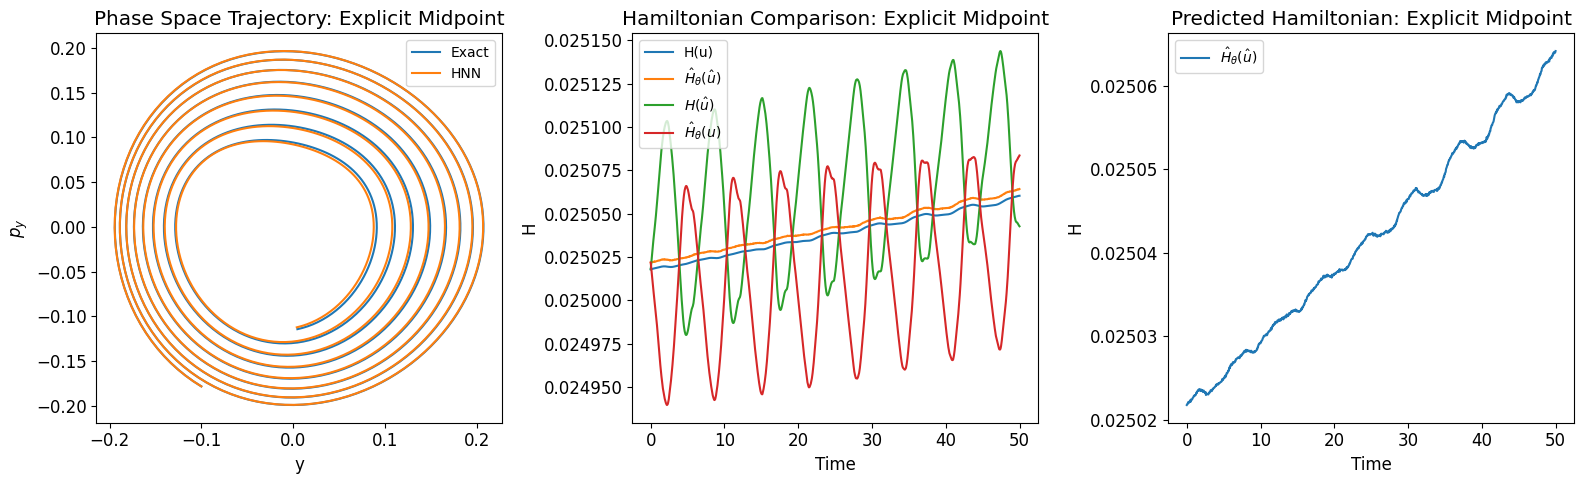

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))  
y, py = u_exact[0][:, 1], u_exact[0][:, 3]
ax[0].plot(y, py, label="Exact")
y, py = u_phnn_exp[0][:, 1], u_phnn_exp[0][:, 3]
ax[0].plot(y, py, label="HNN")
ax[0].set_xlabel("y")
ax[0].set_ylabel(r"$p_y$")
ax[0].set_title("Phase Space Trajectory: Explicit Midpoint" )
ax[0].legend()


H_exact, H_exp_nn, H_exact_pred, H_nn_exact = get_Hamiltonians(model_exp,u_exact,u_phnn_exp,t_sample)
t = t_sample.squeeze(0)

ax[1].plot(t, H_exact, label="H(u)")
ax[1].plot(t, H_exp_nn, label=r"$\hat{H}_{\theta}(\hat u)$")
ax[1].plot(t, H_exact_pred, label=r"$H(\hat u)$")
ax[1].plot(t, H_nn_exact, label=r"$\hat{H}_{\theta}(u)$")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("H")
ax[1].set_title("Hamiltonian Comparison: Explicit Midpoint")
ax[1].legend()

ax[2].plot(t,H_exp_nn, label=r"$\hat{H}_{\theta}(\hat u)$")
ax[2].set_xlabel("Time")
ax[2].set_ylabel("H")
ax[2].set_title("Predicted Hamiltonian: Explicit Midpoint")
ax[2].legend()

plt.tight_layout() 
plt.show()




## Symplectic Euler

100%|██████████| 10/10 [00:04<00:00,  2.33it/s, epoch=9, loss=0.00199]


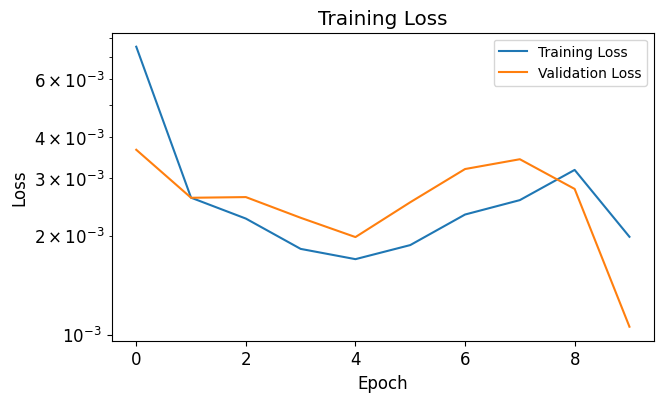

In [16]:
integrator = "symplectic euler"

(u_start, u_end,_, dt), dudt, u_train, u0s_train  =  generate_data(system=sys,ntrajectories =ntraj_train, t_sample = t_train,integrator=integrator, u0s = u0s_train)
train_data = (u_start, u_end, dt), dudt

(u_start, u_end,_, dt), dudt, u_val, u0s_val =  generate_data(system=sys,ntrajectories =ntraj_val, t_sample = t_val,integrator=integrator, u0s = u0s_val)
val_data = (u_start, u_end, dt), dudt

model_symp_eul = HamiltonianNeuralNetwork(nstates = sys.nstates, S=sys.S, sys = sys, Hamiltonian_estimated = BaseHamiltonianNeuralNetwork(nstates=sys.nstates, act_1 = act_1, act_2 = act_2), initial_condition_sampler = initial_condition)

optimizer_symp_eul = torch.optim.Adam(model_symp_eul.parameters(), lr=lr)

trainer = Training(model = model_symp_eul,integrator = integrator, train_data = train_data, val_data = val_data,optimizer = optimizer_symp_eul, system = sys, batch_size=batch_size,epochs = epochs)
model_symp_eul, trainingdetails_symp_eul= trainer.train(loss_func)

In [9]:
model_symp_eul,_,_ = load_model(path= "Models/HenonHeiles/HenonHeiles_symplectic euler_50epoch_PAU()_Softplus(beta=1.0, threshold=20.0)_batchsize_64_shape_torch.Size([175000, 4]).pt")

### Predicting from Symplectic Euler

In [10]:
tmax = 5*10
nsamples = 100*10
dt = tmax/nsamples

nt = round(tmax / dt)
t_sample = np.linspace(0, tmax, nt + 1)

ntrajectories = 1
integrator = "symplectic euler"

(u_start, u_end,_, dt), dudt, u_exact, u0s =  generate_data(system=sys,ntrajectories =ntrajectories, t_sample = t_sample,integrator=integrator,u0s=u0s)

u_phnn_symp_eul, t_sample = model_symp_eul.generate_trajectories(ntrajectories = ntrajectories, t_sample = t_sample,integrator = integrator,u0s=u0s)


100%|██████████| 1/1 [00:00<00:00, 61.90it/s]


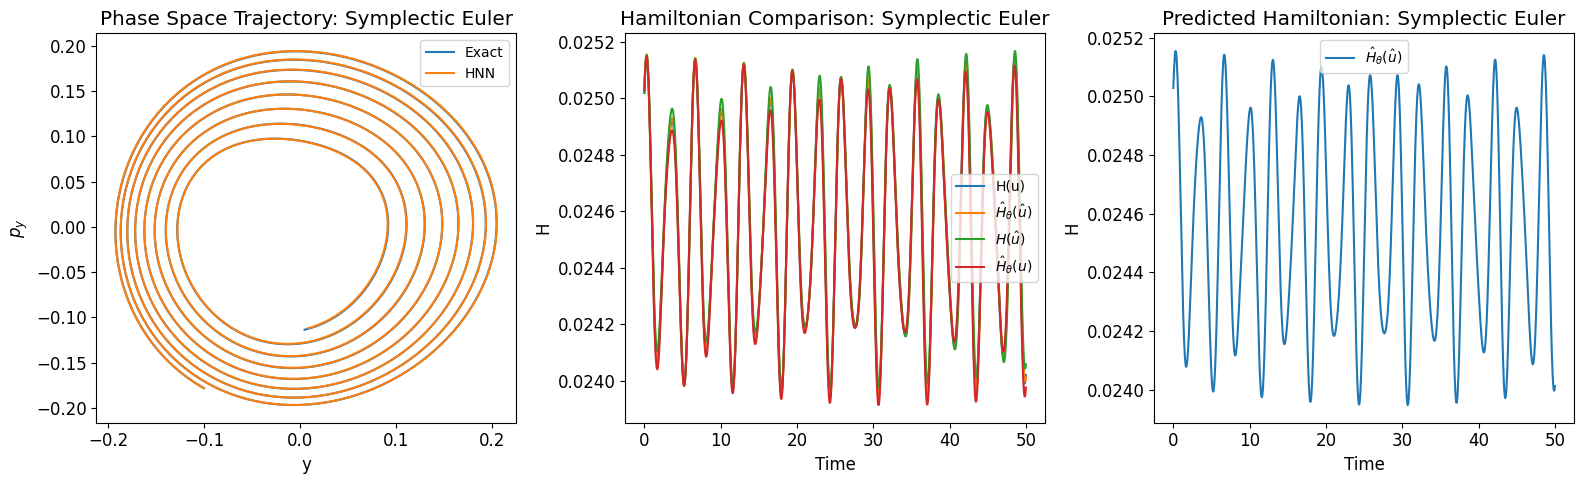

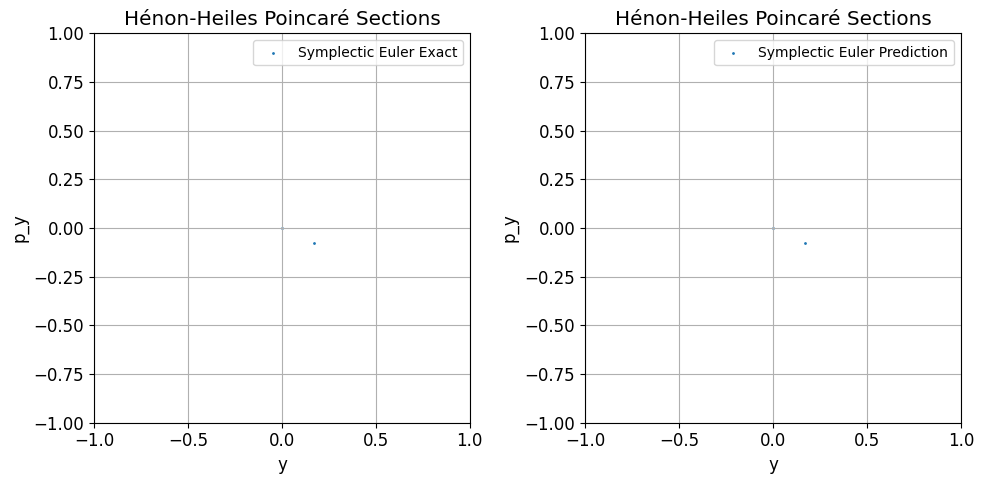

In [11]:

fig, ax = plt.subplots(1, 3, figsize=(16, 5))  
y, py = u_exact[0][:, 1], u_exact[0][:, 3]
ax[0].plot(y, py, label="Exact")
y, py = u_phnn_symp_eul[0][:, 1], u_phnn_symp_eul[0][:, 3]
ax[0].plot(y, py, label="HNN")
ax[0].set_xlabel("y")
ax[0].set_ylabel(r"$p_y$")
ax[0].set_title("Phase Space Trajectory: Symplectic Euler" )
ax[0].legend()

H_exact, H_symp_eul_nn, H_exact_pred, H_nn_exact = get_Hamiltonians(model_symp_eul,u_exact,u_phnn_symp_eul,t_sample)
t = t_sample.squeeze(0)

ax[1].plot(t, H_exact, label="H(u)")
ax[1].plot(t, H_symp_eul_nn, label=r"$\hat{H}_{\theta}(\hat u)$")
ax[1].plot(t, H_exact_pred, label=r"$H(\hat u)$")
ax[1].plot(t, H_nn_exact, label=r"$\hat{H}_{\theta}(u)$")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("H")
ax[1].set_title("Hamiltonian Comparison: Symplectic Euler")
ax[1].legend()

ax[2].plot(t, H_symp_eul_nn, label=r"$\hat{H}_{\theta}(\hat u)$")
ax[2].set_xlabel("Time")
ax[2].set_ylabel("H")
ax[2].set_title("Predicted Hamiltonian: Symplectic Euler")
ax[2].legend()

plt.tight_layout() 
plt.show()


fig, ax = plt.subplots(1, 2, figsize=(10, 5))  

event_indices = np.round(find_crossings(u_exact[0])).astype(int)
y_py = np.array([torch.tensor(u_exact[0][:,0][event_indices]), torch.tensor(u_exact[0][:,1][event_indices])]).T
ax[0].scatter(y_py[0], y_py[1], s=1, label = "Symplectic Euler Exact")
ax[0].legend()
ax[0].set_xlim([-1, 1])
ax[0].set_ylim([-1, 1])
ax[0].set_xlabel("y")
ax[0].set_ylabel("p_y")
ax[0].set_title("Hénon-Heiles Poincaré Sections")
ax[0].grid(True)



event_indices = np.round(find_crossings(u_phnn_symp_eul[0])).astype(int)
y_py = np.array([u_phnn_symp_eul[0][:,0][event_indices], u_phnn_symp_eul[0][:,1][event_indices]]).T
ax[1].scatter(y_py[0], y_py[1], s=1, label = "Symplectic Euler Prediction")
ax[1].legend()
ax[1].set_xlim([-1, 1])
ax[1].set_ylim([-1, 1])
ax[1].set_xlabel("y")
ax[1].set_ylabel("p_y")
ax[1].set_title("Hénon-Heiles Poincaré Sections")
ax[1].grid(True)


plt.tight_layout() 
plt.show()

## Symplectic Midpoint

100%|██████████| 10/10 [00:02<00:00,  4.48it/s, epoch=9, loss=0.000893]


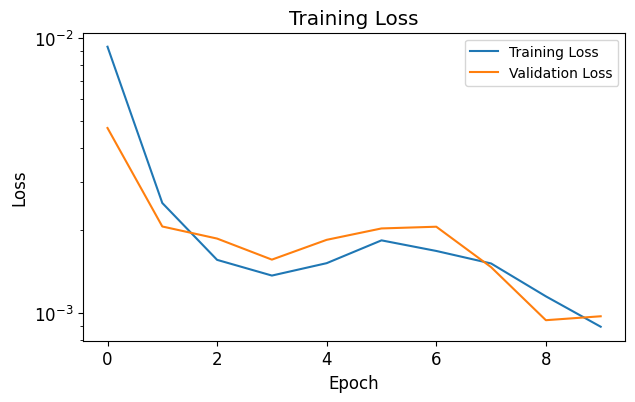

In [19]:
integrator = "symplectic midpoint"

(u_start, u_end,_, dt), dudt, u_train, u0s_train  =  generate_data(system=sys,ntrajectories =ntraj_train, t_sample = t_train,integrator=integrator, u0s = u0s_train)
train_data = (u_start, u_end, dt), dudt

(u_start, u_end,_, dt), dudt, u_val, u0s_val =  generate_data(system=sys,ntrajectories =ntraj_val, t_sample = t_val,integrator=integrator, u0s = u0s_val)
val_data = (u_start, u_end, dt), dudt

model_symp = HamiltonianNeuralNetwork(nstates = sys.nstates, S=sys.S, sys = sys, Hamiltonian_estimated = BaseHamiltonianNeuralNetwork(nstates=sys.nstates, act_1 = act_1, act_2 = act_2), initial_condition_sampler = initial_condition)

optimizer_symp = torch.optim.Adam(model_symp.parameters(), lr=lr)

trainer = Training(model = model_symp,integrator = integrator, train_data = train_data, val_data = val_data,optimizer = optimizer_symp, system = sys, batch_size=batch_size,epochs = epochs)
model_symp, trainingdetails_symp_eul= trainer.train(loss_func)

In [16]:
model_symp,_,_ = load_model(path= "Models/HenonHeiles/HenonHeiles_symplectic midpoint_50epoch_PAU()_Softplus(beta=1.0, threshold=20.0)_batchsize_64_shape_torch.Size([175000, 4]).pt")

### Predicting from Symplectic Midpoint

In [17]:
tmax = 5*10
nsamples = 100*10
dt = tmax/nsamples


nt = round(tmax / dt)
t_sample = np.linspace(0, tmax, nt + 1)

ntrajectories = 1
integrator = "symplectic midpoint"

(u_start, u_end,_, dt), dudt, u_exact, u0s =  generate_data(system=sys,ntrajectories =ntrajectories, t_sample = t_sample,integrator=integrator,u0s=u0s)

u_phnn_symp, t_sample = model_symp.generate_trajectories(ntrajectories = ntrajectories, t_sample = t_sample,integrator = integrator,u0s=u0s)


100%|██████████| 1/1 [00:00<00:00,  8.52it/s]
/Users/sannejamila/Documents/Vår 2025/Prosjektoppgave/Oppgave_github/HNNs_ODEs/HamiltonianNeuralNetwork/HNN.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u0 = torch.tensor(u0,dtype = torch.float32)
/Users/sannejamila/Documents/Vår 2025/Prosjektoppgave/Oppgave_github/HNNs_ODEs/NumericalIntegration/Numerical_Integration.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  guess = torch.tensor(guess, dtype=torch.float32, requires_grad=True)


In [ ]:
u_phnn_symp[:, j, :]  

tensor([[ 0.0044, -0.1088,  0.0873, -0.1723]])

In [30]:
u_phnn_symp[0]

tensor([[ 0.0000, -0.1000,  0.0874, -0.1781],
        [ 0.0044, -0.1088,  0.0873, -0.1723],
        [ 0.0088, -0.1173,  0.0870, -0.1661],
        ...,
        [-0.1557,  0.0216,  0.1095, -0.1108],
        [-0.1501,  0.0160,  0.1174, -0.1129],
        [-0.1440,  0.0103,  0.1250, -0.1146]])

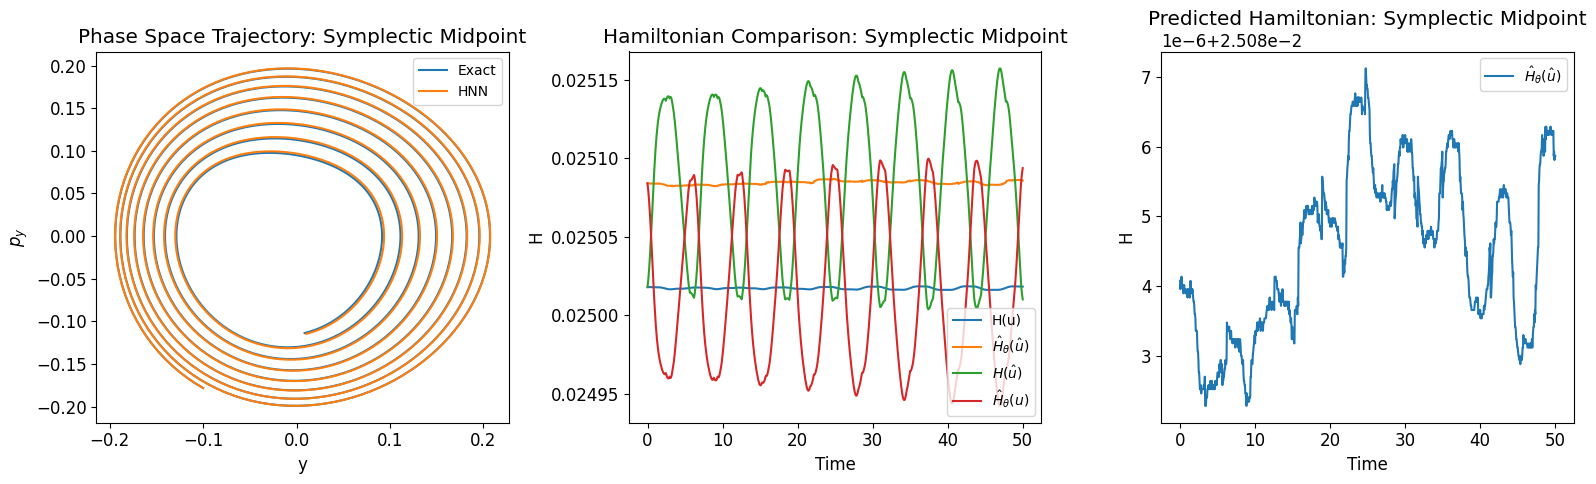

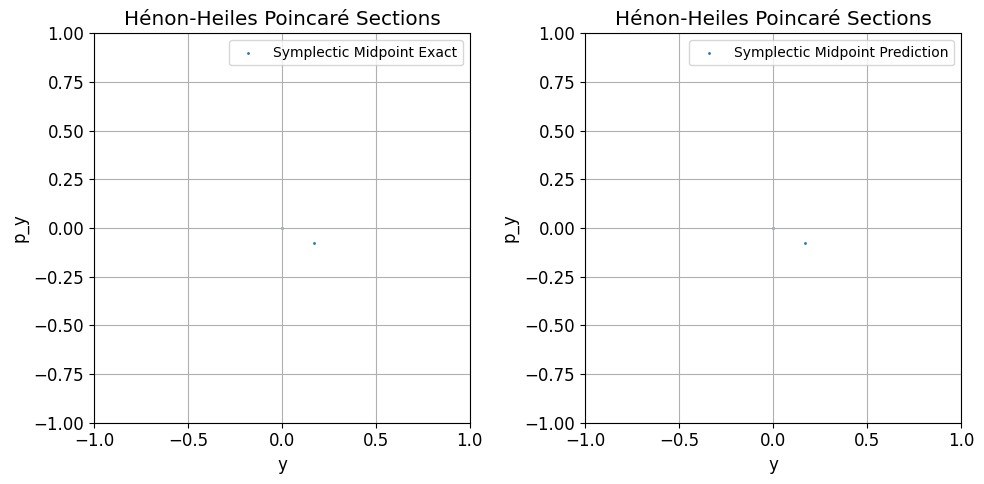

In [15]:

fig, ax = plt.subplots(1, 3, figsize=(16, 5))  
y, py = u_exact[0][:, 1], u_exact[0][:, 3]
ax[0].plot(y, py, label="Exact")
y, py = u_phnn_symp[0][:, 1], u_phnn_symp[0][:, 3]
ax[0].plot(y, py, label="HNN")
ax[0].set_xlabel("y")
ax[0].set_ylabel(r"$p_y$")
ax[0].set_title("Phase Space Trajectory: Symplectic Midpoint" )
ax[0].legend()

H_exact, H_symp_nn, H_exact_pred, H_nn_exact = get_Hamiltonians(model_symp,u_exact,u_phnn_symp,t_sample)
t = t_sample.squeeze(0)

ax[1].plot(t, H_exact, label="H(u)")
ax[1].plot(t, H_symp_nn, label=r"$\hat{H}_{\theta}(\hat u)$")
ax[1].plot(t, H_exact_pred, label=r"$H(\hat u)$")
ax[1].plot(t, H_nn_exact, label=r"$\hat{H}_{\theta}(u)$")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("H")
ax[1].set_title("Hamiltonian Comparison: Symplectic Midpoint")
ax[1].legend()

ax[2].plot(t, H_symp_nn, label=r"$\hat{H}_{\theta}(\hat u)$")
ax[2].set_xlabel("Time")
ax[2].set_ylabel("H")
ax[2].set_title("Predicted Hamiltonian: Symplectic Midpoint")
ax[2].legend()
plt.tight_layout() 
plt.show()


fig, ax = plt.subplots(1, 2, figsize=(10, 5))  

event_indices = np.round(find_crossings(u_exact[0])).astype(int)
y_py = np.array([torch.tensor(u_exact[0][:,0][event_indices]), torch.tensor(u_exact[0][:,1][event_indices])]).T
ax[0].scatter(y_py[0], y_py[1], s=1, label = "Symplectic Midpoint Exact")
ax[0].legend()
ax[0].set_xlim([-1, 1])
ax[0].set_ylim([-1, 1])
ax[0].set_xlabel("y")
ax[0].set_ylabel("p_y")
ax[0].set_title("Hénon-Heiles Poincaré Sections")
ax[0].grid(True)



event_indices = np.round(find_crossings(u_phnn_symp[0])).astype(int)
y_py = np.array([u_phnn_symp[0][:,0][event_indices], u_phnn_symp[0][:,1][event_indices]]).T
ax[1].scatter(y_py[0], y_py[1], s=1, label = "Symplectic Midpoint Prediction")
ax[1].legend()
ax[1].set_xlim([-1, 1])
ax[1].set_ylim([-1, 1])
ax[1].set_xlabel("y")
ax[1].set_ylabel("p_y")
ax[1].set_title("Hénon-Heiles Poincaré Sections")
ax[1].grid(True)


plt.tight_layout() 
plt.show()

## Error Analysis - Comparing Activation Functions

### Loading Models

In [36]:
model_exp_PAU_ReLU, _, loss_exp_PAU_ReLU = load_model("Models/HenonHeiles/HenonHeiles_midpoint_50epoch_PAU()_ReLU()_batchsize_64_shape_torch.Size([175000, 4]).pt")
model_exp_PAU_Soft, _, loss_exp_PAU_Soft = load_model("Models/HenonHeiles/HenonHeiles_midpoint_50epoch_PAU()_Softplus(beta=1.0, threshold=20.0)_batchsize_64_shape_torch.Size([175000, 4]).pt")
model_exp_Sin_ReLU, _, loss_exp_Sin_ReLU = load_model("Models/HenonHeiles/HenonHeiles_midpoint_50epoch_Sin()_ReLU()_batchsize_64_shape_torch.Size([175000, 4]).pt")
model_exp_Sin_Soft, _, loss_exp_Sin_Soft = load_model("Models/HenonHeiles/HenonHeiles_midpoint_50epoch_Sin()_Softplus(beta=1.0, threshold=20.0)_batchsize_64_shape_torch.Size([175000, 4]).pt")
model_exp_Tanh_ReLU, _, loss_exp_Tanh_ReLU = load_model("Models/HenonHeiles/HenonHeiles_midpoint_50epoch_Tanh()_ReLU()_batchsize_64_shape_torch.Size([175000, 4]).pt")
model_exp_Tanh_soft, _, loss_exp_Tanh_soft = load_model("Models/HenonHeiles/HenonHeiles_midpoint_50epoch_Tanh()_Softplus(beta=1.0, threshold=20.0)_batchsize_64_shape_torch.Size([175000, 4]).pt")


model_symp_eul_PAU_ReLU, _, loss_symp_eul_PAU_ReLU = load_model("Models/HenonHeiles/HenonHeiles_symplectic euler_50epoch_PAU()_ReLU()_batchsize_64_shape_torch.Size([175000, 4]).pt")
model_symp_eul_PAU_Soft, _, loss_symp_eul_PAU_Soft = load_model("Models/HenonHeiles/HenonHeiles_symplectic euler_50epoch_PAU()_Softplus(beta=1.0, threshold=20.0)_batchsize_64_shape_torch.Size([175000, 4]).pt")
model_symp_eul_Sin_ReLU, _, loss_symp_eul_Sin_ReLU = load_model("Models/HenonHeiles/HenonHeiles_symplectic euler_50epoch_Sin()_ReLU()_batchsize_64_shape_torch.Size([175000, 4]).pt")
model_symp_eul_Sin_Soft, _, loss_symp_eul_Sin_Soft = load_model("Models/HenonHeiles/HenonHeiles_symplectic euler_50epoch_Sin()_Softplus(beta=1.0, threshold=20.0)_batchsize_64_shape_torch.Size([175000, 4]).pt")
model_symp_eul_Tanh_ReLU, _, loss_symp_eul_Tanh_ReLU = load_model("Models/HenonHeiles/HenonHeiles_symplectic euler_50epoch_Tanh()_ReLU()_batchsize_64_shape_torch.Size([175000, 4]).pt")
model_symp_eul_Tanh_soft, _, loss_symp_eul_Tanh_soft = load_model("Models/HenonHeiles/HenonHeiles_symplectic euler_50epoch_Tanh()_Softplus(beta=1.0, threshold=20.0)_batchsize_64_shape_torch.Size([175000, 4]).pt")


model_symp_PAU_ReLU, _, loss_symp_PAU_ReLU = load_model("Models/HenonHeiles/HenonHeiles_symplectic midpoint_50epoch_PAU()_ReLU()_batchsize_64_shape_torch.Size([175000, 4]).pt")
model_symp_PAU_Soft, _, loss_symp_PAU_Soft = load_model("Models/HenonHeiles/HenonHeiles_symplectic midpoint_50epoch_PAU()_Softplus(beta=1.0, threshold=20.0)_batchsize_64_shape_torch.Size([175000, 4]).pt")
model_symp_Sin_ReLU, _, loss_symp_Sin_ReLU = load_model("Models/HenonHeiles/HenonHeiles_symplectic midpoint_50epoch_Sin()_ReLU()_batchsize_64_shape_torch.Size([175000, 4]).pt")
model_symp_Sin_Soft, _, loss_symp_Sin_Soft = load_model("Models/HenonHeiles/HenonHeiles_symplectic midpoint_50epoch_Sin()_Softplus(beta=1.0, threshold=20.0)_batchsize_64_shape_torch.Size([175000, 4]).pt")
model_symp_Tanh_ReLU, _, loss_symp_Tanh_ReLU = load_model("Models/HenonHeiles/HenonHeiles_symplectic midpoint_50epoch_Tanh()_ReLU()_batchsize_64_shape_torch.Size([175000, 4]).pt")
model_symp_Tanh_soft, _, loss_symp_Tanh_soft = load_model("Models/HenonHeiles/HenonHeiles_symplectic midpoint_50epoch_Tanh()_Softplus(beta=1.0, threshold=20.0)_batchsize_64_shape_torch.Size([175000, 4]).pt")


### Plotting Training Loss Error - Each Activation Function

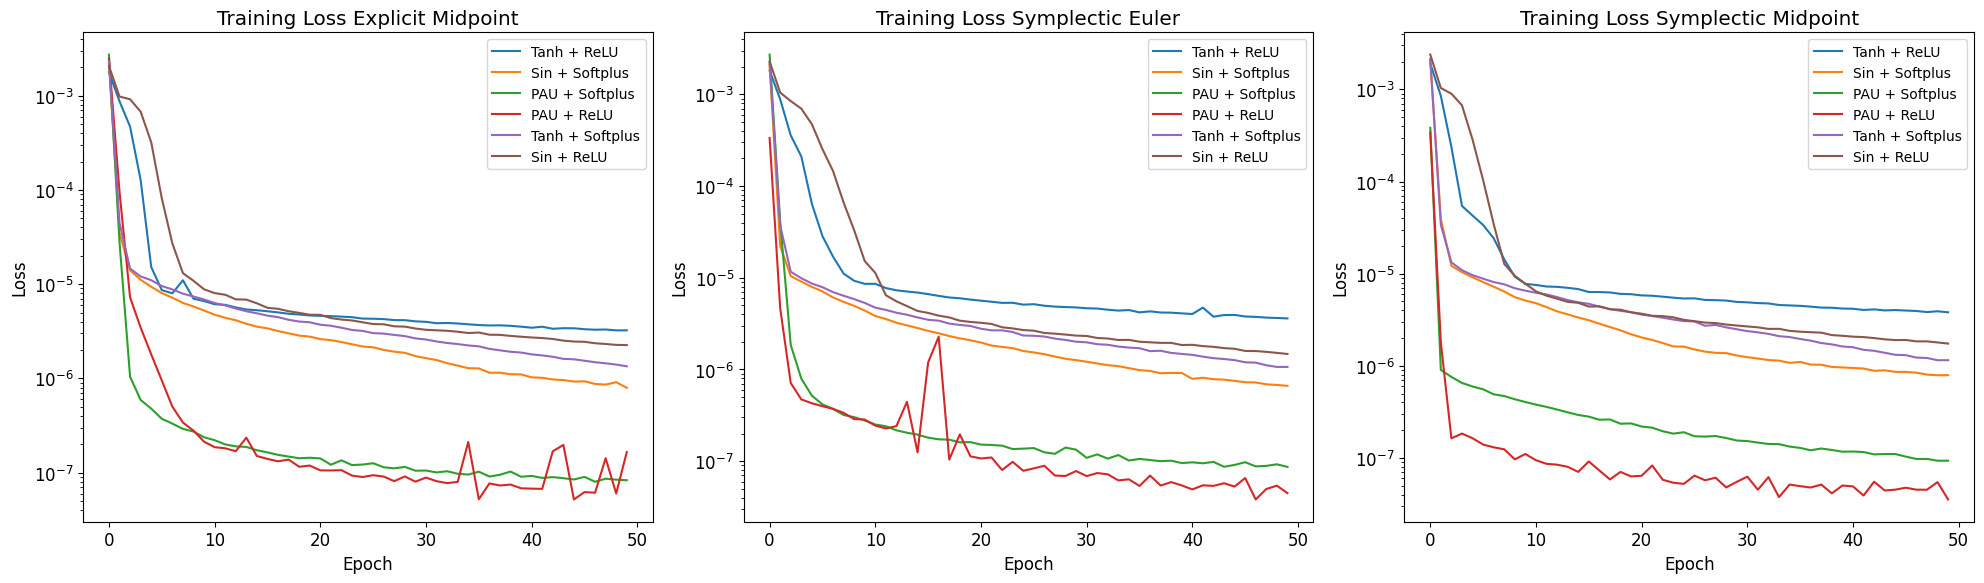

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

ax[0].plot(loss_exp_Tanh_ReLU, label = "Tanh + ReLU")
ax[0].plot(loss_exp_Sin_Soft, label = "Sin + Softplus")
ax[0].plot(loss_exp_PAU_Soft, label = "PAU + Softplus")
ax[0].plot(loss_exp_PAU_ReLU, label = "PAU + ReLU")
ax[0].plot(loss_exp_Tanh_soft, label = "Tanh + Softplus")
ax[0].plot(loss_exp_Sin_ReLU, label = "Sin + ReLU")
ax[0].legend()
ax[0].set_yscale('log')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training Loss: Explicit Midpoint')



ax[1].plot(loss_symp_eul_Tanh_ReLU, label = "Tanh + ReLU")
ax[1].plot(loss_symp_eul_Sin_Soft, label = "Sin + Softplus")
ax[1].plot(loss_symp_eul_PAU_Soft, label = "PAU + Softplus")
ax[1].plot(loss_symp_eul_PAU_ReLU, label = "PAU + ReLU")
ax[1].plot(loss_symp_eul_Tanh_soft, label = "Tanh + Softplus")
ax[1].plot(loss_symp_eul_Sin_ReLU, label = "Sin + ReLU")
ax[1].legend()
ax[1].set_yscale('log')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title('Training Loss: Symplectic Euler')

ax[2].plot(loss_symp_Tanh_ReLU, label = "Tanh + ReLU")
ax[2].plot(loss_symp_Sin_Soft, label = "Sin + Softplus")
ax[2].plot(loss_symp_PAU_Soft, label = "PAU + Softplus")
ax[2].plot(loss_symp_PAU_ReLU, label = "PAU + ReLU")
ax[2].plot(loss_symp_Tanh_soft, label = "Tanh + Softplus")
ax[2].plot(loss_symp_Sin_ReLU, label = "Sin + ReLU")
ax[2].legend()
ax[2].set_yscale('log')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Loss')
ax[2].set_title('Training Loss: Symplectic Midpoint')

plt.tight_layout() 
plt.show()


## Test Error Analysis - Comparing Activation Functions

In [ ]:
#def test_loss(pred,exact):
    #return ((pred-exact)**2).mean()

### Predicting Test Data

In [74]:
T_max_test = 20
nsamples_test = 100*2
ntraj_test = 100

dt_test = T_max_test/nsamples_test
nt_test = round(T_max_test / dt_test)
t_test = np.linspace(0, T_max_test, nt_test + 1)

sys = HenonHeilesSystem()
traject = np.linspace(1,ntraj_test,ntraj_test)

In [75]:
(u_start, u_end,_, dt), dudt, u_test_exp, u0_test = generate_data(ntrajectories = ntraj_test, t_sample = t_test,system= sys,integrator = "midpoint")
(u_start, u_end,_, dt), dudt, u_test_symp_eul, u0_test= generate_data(ntrajectories = ntraj_test, t_sample = t_test,system= sys,integrator = "symplectic euler",u0s = u0_test)
(u_start, u_end,_, dt), dudt, u_test_symp, u0_test= generate_data(ntrajectories = ntraj_test, t_sample = t_test,system= sys,integrator = "symplectic midpoint",u0s = u0_test)

100%|██████████| 100/100 [00:02<00:00, 35.91it/s]


In [76]:
u_exp_PAU_Soft, _ = model_exp_PAU_Soft.generate_trajectories(ntrajectories = ntraj_test, t_sample = t_test,integrator = "midpoint",u0s=u0_test)
print("Explicit Midpoint with PAU and Softplus done")
u_exp_Sin_Soft, _ = model_exp_Sin_Soft.generate_trajectories(ntrajectories = ntraj_test, t_sample = t_test,integrator = "midpoint",u0s=u0_test)
print("Explicit Midpoint with Sin and Softplus done")
u_exp_Tanh_ReLU, _ = model_exp_Tanh_ReLU.generate_trajectories(ntrajectories = ntraj_test, t_sample = t_test,integrator = "midpoint",u0s=u0_test)
print("Explicit Midpoint with Tanh and ReLU done")
u_exp_PAU_ReLU, _ = model_exp_PAU_ReLU.generate_trajectories(ntrajectories = ntraj_test, t_sample = t_test,integrator = "midpoint",u0s=u0_test)
print("Explicit Midpoint with PAU and ReLU done")
u_exp_Tanh_soft, _ = model_exp_Tanh_soft.generate_trajectories(ntrajectories = ntraj_test, t_sample = t_test,integrator = "midpoint",u0s=u0_test)
print("Explicit Midpoint with Tanh and Softplus done")
u_exp_Sin_ReLU, _ = model_exp_Sin_ReLU.generate_trajectories(ntrajectories = ntraj_test, t_sample = t_test,integrator = "midpoint",u0s=u0_test)
print("Explicit Midpoint with Sin and ReLU done")

Explicit Midpoint with PAU and Softplus done
Explicit Midpoint with Sin and Softplus done
Explicit Midpoint with Tanh and ReLU done
Explicit Midpoint with PAU and ReLU done
Explicit Midpoint with Tanh and Softplus done
Explicit Midpoint with Sin and ReLU done


In [77]:
def test_loss(pred,exact):
    mse_per_time = torch.mean((pred - exact) ** 2, dim=(0, 2)) 
    return mse_per_time

mse_per_time = test_loss(u_exp_PAU_Soft,u_test_exp)

/var/folders/hz/4gdmfnt15kl39xg3l41t9hr00000gn/T/ipykernel_18568/331684558.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  mse_per_time = torch.mean((pred - exact) ** 2, dim=(0, 2))


In [78]:
u_symp_eul_PAU_Soft, _ = model_symp_eul_PAU_Soft.generate_trajectories(ntrajectories = ntraj_test, t_sample = t_test,integrator = "symplectic euler",u0s=u0_test)
print("Symplectic Euler with PAU and Softplus done")
u_symp_eul_Sin_Soft, _ = model_symp_eul_Sin_Soft.generate_trajectories(ntrajectories = ntraj_test, t_sample = t_test,integrator = "symplectic euler",u0s=u0_test)
print("Symplectic Euler with Sin and Softplus done")
u_symp_eul_Tanh_ReLU, _ = model_symp_eul_Tanh_ReLU.generate_trajectories(ntrajectories = ntraj_test, t_sample = t_test,integrator = "symplectic euler",u0s=u0_test)
print("Symplectic Euler with Tanh and ReLU done")
u_symp_eul_PAU_ReLU, _ = model_symp_eul_PAU_ReLU.generate_trajectories(ntrajectories = ntraj_test, t_sample = t_test,integrator = "symplectic euler",u0s=u0_test)
print("Symplectic Euler with PAU and ReLY done")
u_symp_eul_Tanh_soft, _ = model_symp_eul_Tanh_soft.generate_trajectories(ntrajectories = ntraj_test, t_sample = t_test,integrator = "symplectic euler",u0s=u0_test)
print("Symplectic Euler with Tanh and Softplus done")
u_symp_eul_Sin_ReLU, _ = model_symp_eul_Sin_ReLU.generate_trajectories(ntrajectories = ntraj_test, t_sample = t_test,integrator = "symplectic euler",u0s=u0_test)
print("Symplectic Euler with Sin and ReLU done")

Symplectic Euler with PAU and Softplus done
Symplectic Euler with Sin and Softplus done
Symplectic Euler with Tanh and ReLU done
Symplectic Euler with PAU and ReLY done
Symplectic Euler with Tanh and Softplus done
Symplectic Euler with Sin and ReLU done


In [79]:
u_symp_PAU_Soft, _ = model_symp_PAU_Soft.generate_trajectories(ntrajectories = ntraj_test, t_sample = t_test,integrator = "symplectic midpoint",u0s=u0_test)
print("Symplectic Midpoint with PAU and Softplus done")
u_symp_Sin_Soft, _ = model_symp_Sin_Soft.generate_trajectories(ntrajectories = ntraj_test, t_sample = t_test,integrator = "symplectic midpoint",u0s=u0_test)
print("Symplectic Midpoint with Sin and Softplus done")
u_symp_Tanh_ReLU, _ = model_symp_Tanh_ReLU.generate_trajectories(ntrajectories = ntraj_test, t_sample = t_test,integrator = "symplectic midpoint",u0s=u0_test)
print("Symplectic Midpoint with Tanh and ReLU done")
u_symp_PAU_ReLU, _ = model_symp_PAU_ReLU.generate_trajectories(ntrajectories = ntraj_test, t_sample = t_test,integrator = "symplectic midpoint",u0s=u0_test)
print("Symplectic Midpoint with PAU and ReLU done")
u_symp_Tanh_soft, _ = model_symp_Tanh_soft.generate_trajectories(ntrajectories = ntraj_test, t_sample = t_test,integrator = "symplectic midpoint",u0s=u0_test)
print("Symplectic Midpoint with Tanh and Softplus done")
u_symp_Sin_ReLU, _ = model_symp_Sin_ReLU.generate_trajectories(ntrajectories = ntraj_test, t_sample = t_test,integrator = "symplectic midpoint",u0s=u0_test)
print("Symplectic Midpoint with Sin and ReLU done")

/Users/sannejamila/Documents/Vår 2025/Prosjektoppgave/Oppgave_github/HNNs_ODEs/NumericalIntegration/Numerical_Integration.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  guess = torch.tensor(guess, dtype=torch.float32, requires_grad=True)


Symplectic Midpoint with PAU and Softplus done
Symplectic Midpoint with Sin and Softplus done
Symplectic Midpoint with Tanh and ReLU done
Symplectic Midpoint with PAU and ReLU done
Symplectic Midpoint with Tanh and Softplus done
Symplectic Midpoint with Sin and ReLU done


#### Test Loss Comparison - Coordinates

In [80]:
err_exp_PAU_Soft = test_loss(u_exp_PAU_Soft,u_test_exp)
err_exp_Sin_Soft = test_loss(u_exp_Sin_Soft,u_test_exp)
err_exp_Tanh_ReLU = test_loss(u_exp_Tanh_ReLU,u_test_exp)
err_exp_PAU_ReLU = test_loss(u_exp_PAU_ReLU,u_test_exp)
err_exp_Tanh_soft = test_loss(u_exp_Tanh_soft,u_test_exp)
err_exp_Sin_ReLU = test_loss(u_exp_Sin_ReLU,u_test_exp)

err_symp_eul_PAU_Soft =test_loss(u_symp_eul_PAU_Soft,u_test_symp_eul)
err_symp_eul_Sin_Soft = test_loss(u_symp_eul_Sin_Soft,u_test_symp_eul)
err_symp_eul_Tanh_ReLU = test_loss(u_symp_eul_Tanh_ReLU,u_test_symp_eul)
err_symp_eul_PAU_ReLU = test_loss(u_symp_eul_PAU_ReLU,u_test_symp_eul)
err_symp_eul_Tanh_soft = test_loss(u_symp_eul_Tanh_soft,u_test_symp_eul)
err_symp_eul_Sin_ReLU = test_loss(u_symp_eul_Sin_ReLU,u_test_symp_eul)


err_symp_PAU_Soft =test_loss(u_symp_PAU_Soft,u_test_symp)
err_symp_Sin_Soft = test_loss(u_symp_Sin_Soft,u_test_symp)
err_symp_Tanh_ReLU = test_loss(u_symp_Tanh_ReLU,u_test_symp)
err_symp_PAU_ReLU = test_loss(u_symp_PAU_ReLU,u_test_symp)
err_symp_Tanh_soft = test_loss(u_symp_Tanh_soft,u_test_symp)
err_symp_Sin_ReLU = test_loss(u_symp_Sin_ReLU,u_test_symp)

/var/folders/hz/4gdmfnt15kl39xg3l41t9hr00000gn/T/ipykernel_18568/331684558.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  mse_per_time = torch.mean((pred - exact) ** 2, dim=(0, 2))


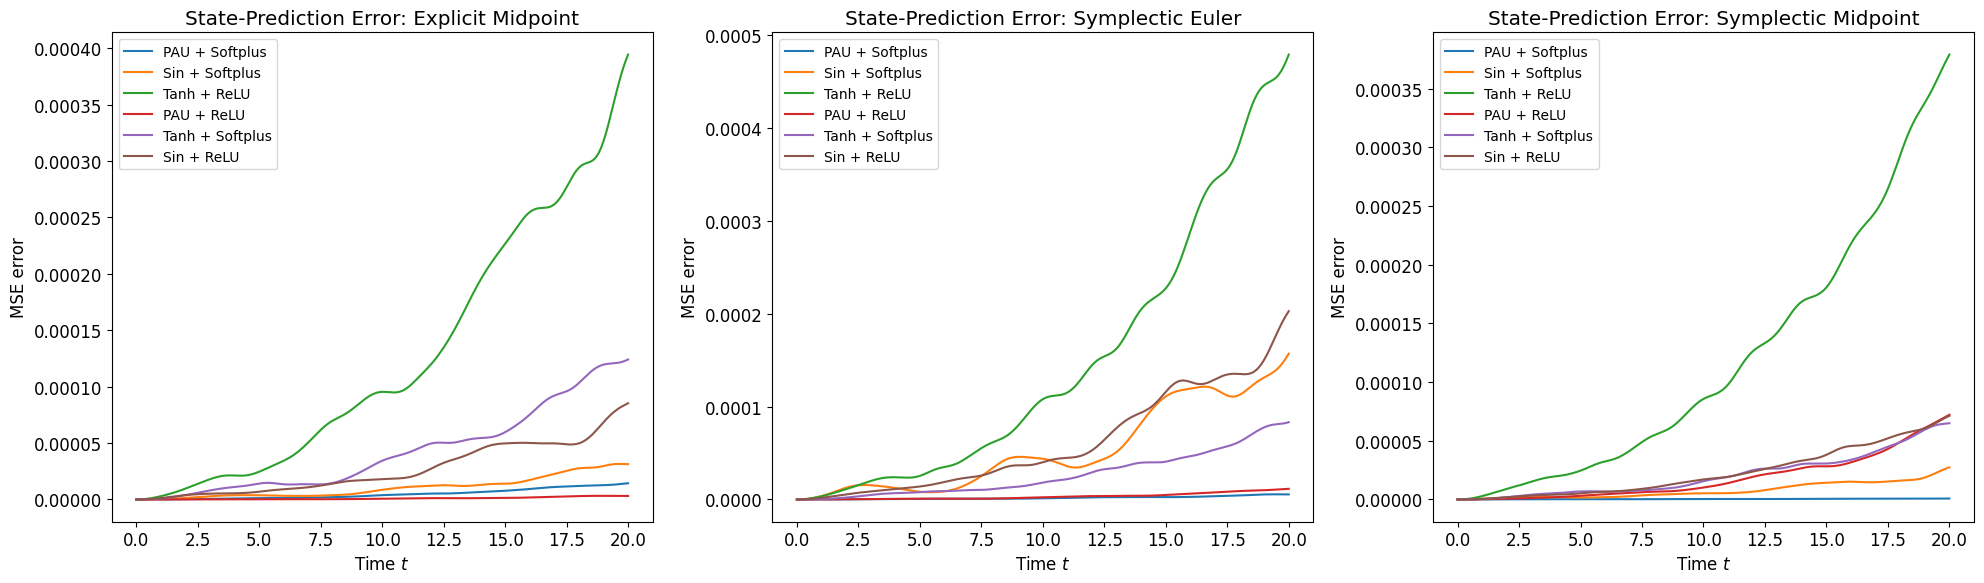

In [81]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))


ax[0].plot(t_test, err_exp_PAU_Soft, label="PAU + Softplus")
ax[0].plot(t_test, err_exp_Sin_Soft, label="Sin + Softplus")
ax[0].plot(t_test, err_exp_Tanh_ReLU, label="Tanh + ReLU")
ax[0].plot(t_test, err_exp_PAU_ReLU, label="PAU + ReLU")
ax[0].plot(t_test, err_exp_Tanh_soft, label="Tanh + Softplus")
ax[0].plot(t_test, err_exp_Sin_ReLU, label="Sin + ReLU")
ax[0].set_xlabel(f"Time $t$")
ax[0].set_ylabel("MSE error")
ax[0].set_title("State-Prediction Error: Explicit Midpoint")
ax[0].legend()



ax[1].plot(t_test, err_symp_eul_PAU_Soft, label="PAU + Softplus")
ax[1].plot(t_test, err_symp_eul_Sin_Soft, label="Sin + Softplus")
ax[1].plot(t_test, err_symp_eul_Tanh_ReLU, label="Tanh + ReLU")
ax[1].plot(t_test, err_symp_eul_PAU_ReLU, label="PAU + ReLU")
ax[1].plot(t_test, err_symp_eul_Tanh_soft, label="Tanh + Softplus")
ax[1].plot(t_test, err_symp_eul_Sin_ReLU, label="Sin + ReLU")
ax[1].set_xlabel(f"Time $t$")
ax[1].set_ylabel("MSE error")
ax[1].set_title("State-Prediction Error: Symplectic Euler")
ax[1].legend()


ax[2].plot(t_test, err_symp_PAU_Soft, label="PAU + Softplus")
ax[2].plot(t_test, err_symp_Sin_Soft, label="Sin + Softplus")
ax[2].plot(t_test, err_symp_Tanh_ReLU, label="Tanh + ReLU")
ax[2].plot(t_test, err_symp_PAU_ReLU, label="PAU + ReLU")
ax[2].plot(t_test, err_symp_Tanh_soft, label="Tanh + Softplus")
ax[2].plot(t_test, err_symp_Sin_ReLU, label="Sin + ReLU")
ax[2].set_xlabel(f"Time $t$")
ax[2].set_ylabel("MSE error")
ax[2].set_title("State-Prediction Error: Symplectic Midpoint")
ax[2].legend()

plt.tight_layout() 
plt.show()

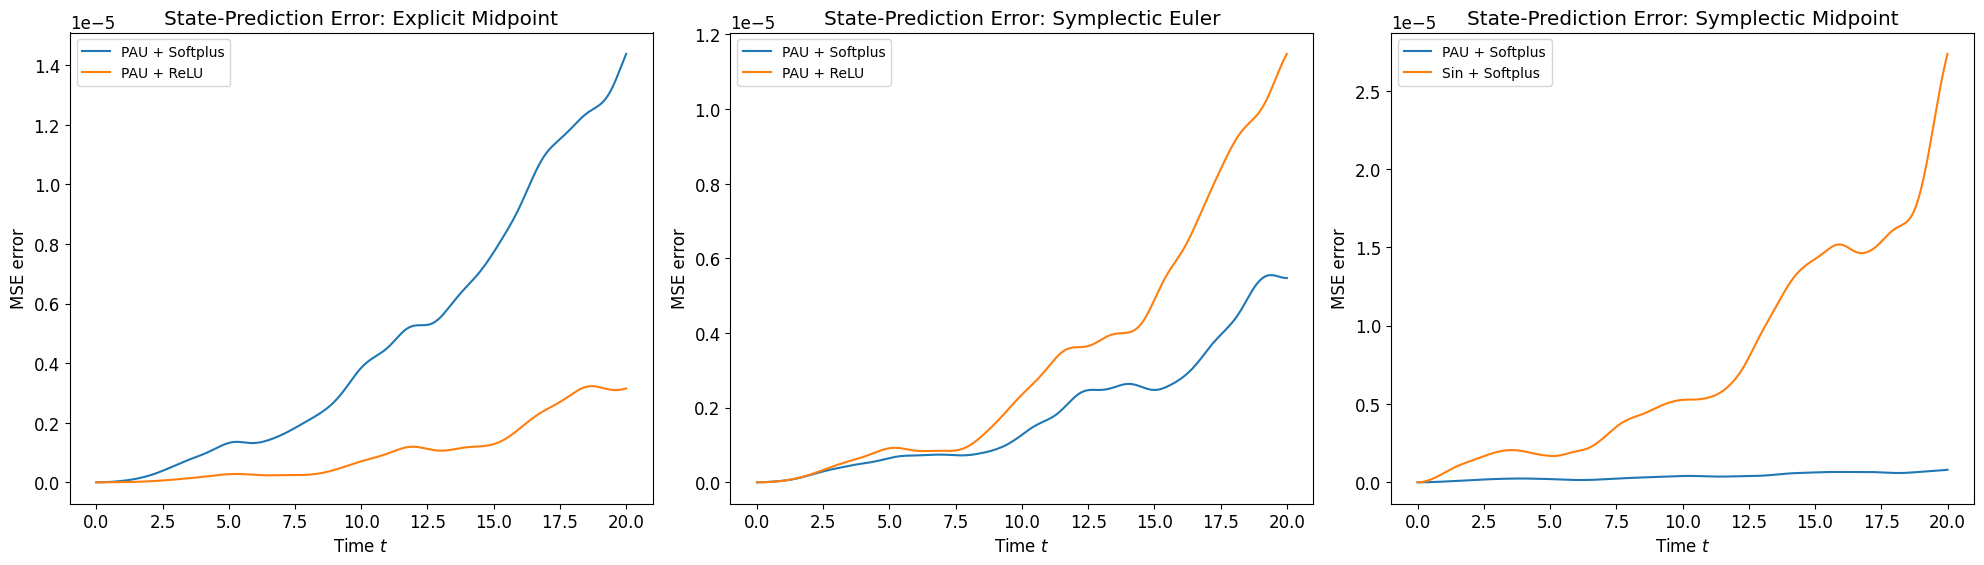

In [82]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))



ax[0].plot(t_test, err_exp_PAU_Soft, label="PAU + Softplus")
ax[0].plot(t_test, err_exp_PAU_ReLU, label="PAU + ReLU")
ax[0].set_xlabel(f"Time $t$")
ax[0].set_ylabel("MSE error")
ax[0].set_title("State-Prediction Error: Explicit Midpoint")
ax[0].legend()


ax[1].plot(t_test, err_symp_eul_PAU_Soft, label="PAU + Softplus")
ax[1].plot(t_test, err_symp_eul_PAU_ReLU, label="PAU + ReLU")
ax[1].set_xlabel(f"Time $t$")
ax[1].set_ylabel("MSE error")
ax[1].set_title("State-Prediction Error: Symplectic Euler")
ax[1].legend()



ax[2].plot(t_test, err_symp_PAU_Soft, label="PAU + Softplus")
ax[2].plot(t_test, err_symp_Sin_Soft, label="Sin + Softplus")
ax[2].set_xlabel(f"Time $t$")
ax[2].set_ylabel("MSE error")
ax[2].set_title("State-Prediction Error: Symplectic Midpoint")
ax[2].legend()


plt.tight_layout() 
plt.show()

### Test Error of Hamiltonian - Comparing Activation Functions

In [83]:
"""
def get_Hamiltonians(model,u_exact,u_pred, sys = HenonHeilesSystem()):
    H_exact = torch.tensor([sys.Hamiltonian(u) for u in u_exact])

    u_samples = u_pred
    #Computed estimated Hamiltonian from values for prediction
    H_nn= torch.tensor([(model.Hamiltonian(u)- model.Hamiltonian(torch.tensor([[0.,  0.,  0.,  0.]])) )for u in u_samples])
    #Computed true Hamiltonian values for prediction
    H_exact_pred = torch.tensor([sys.Hamiltonian(u) for u in u_samples])
    #Computed NN Hamiltonian for exact
    H_nn_exact = torch.tensor([(model.Hamiltonian(torch.tensor(u, dtype = torch.float32)) - model.Hamiltonian(torch.tensor([[0., 0., 0., 0.]]))) for u in u_exact])


    return H_exact, H_nn, H_exact_pred, H_nn_exact

"""

'\ndef get_Hamiltonians(model,u_exact,u_pred, sys = HenonHeilesSystem()):\n    H_exact = torch.tensor([sys.Hamiltonian(u) for u in u_exact])\n\n    u_samples = u_pred\n    #Computed estimated Hamiltonian from values for prediction\n    H_nn= torch.tensor([(model.Hamiltonian(u)- model.Hamiltonian(torch.tensor([[0.,  0.,  0.,  0.]])) )for u in u_samples])\n    #Computed true Hamiltonian values for prediction\n    H_exact_pred = torch.tensor([sys.Hamiltonian(u) for u in u_samples])\n    #Computed NN Hamiltonian for exact\n    H_nn_exact = torch.tensor([(model.Hamiltonian(torch.tensor(u, dtype = torch.float32)) - model.Hamiltonian(torch.tensor([[0., 0., 0., 0.]]))) for u in u_exact])\n\n\n    return H_exact, H_nn, H_exact_pred, H_nn_exact\n\n'

In [84]:
def get_Hamiltonians(model, u_exact, u_pred, sys=HenonHeilesSystem()):
    """
    u_exact: numpy array of shape [N, T, 4]
    u_pred:  torch tensor of shape [N, T, 4]
    Returns:
        All Hamiltonians as tensors of shape [N, T, 1]
    """
    # Convert numpy array to torch tensor
    u_exact = torch.tensor(u_exact, dtype=torch.float32)

    N, T, d = u_exact.shape
    u_exact_flat = u_exact.reshape(-1, d)
    u_pred_flat = u_pred.reshape(-1, d)

    zero_state = torch.tensor([[0., 0., 0., 0.]], dtype=torch.float32)

    # Compute Hamiltonians
    H_exact = torch.tensor(
        [sys.Hamiltonian(u) for u in u_exact_flat], dtype=torch.float32
    ).reshape(N, T, 1)

    H_nn = torch.tensor(
        [model.Hamiltonian(u) - model.Hamiltonian(zero_state) for u in u_pred_flat],
        dtype=torch.float32
    ).reshape(N, T, 1)

    H_exact_pred = torch.tensor(
        [sys.Hamiltonian(u) for u in u_pred_flat], dtype=torch.float32
    ).reshape(N, T, 1)

    H_nn_exact = torch.tensor(
        [model.Hamiltonian(u) - model.Hamiltonian(zero_state) for u in u_exact_flat],
        dtype=torch.float32
    ).reshape(N, T, 1)

    return H_exact, H_nn, H_exact_pred, H_nn_exact


In [85]:
H_exact,H_model, H_exact_pred, H_model_exact = get_Hamiltonians(u_exact = u_test_exp,u_pred = u_exp_PAU_Soft,model= model_exp_PAU_Soft)
H_err_exp_PAU_Soft = test_loss(H_model_exact,H_exact)
H_exact,H_model, H_exact_pred, H_model_exact = get_Hamiltonians(u_exact = u_test_exp,u_pred = u_exp_Sin_Soft,model= model_exp_Sin_Soft)
H_err_exp_Sin_Soft = test_loss(H_model_exact,H_exact)
H_exact,H_model, H_exact_pred, H_model_exact = get_Hamiltonians(u_exact = u_test_exp,u_pred = u_exp_Tanh_ReLU,model= model_exp_Tanh_ReLU)
H_err_exp_Tanh_ReLU = test_loss(H_model_exact,H_exact)
H_exact,H_model, H_exact_pred, H_model_exact = get_Hamiltonians(u_exact = u_test_exp,u_pred = u_exp_PAU_ReLU,model= model_exp_PAU_ReLU)
H_err_exp_PAU_ReLU =  test_loss(H_model_exact,H_exact)
H_exact,H_model, H_exact_pred, H_model_exact = get_Hamiltonians(u_exact = u_test_exp,u_pred = u_exp_Tanh_soft,model= model_exp_Tanh_soft)
H_err_exp_Tanh_soft =  test_loss(H_model_exact,H_exact)
H_exact,H_model, H_exact_pred, H_model_exact = get_Hamiltonians(u_exact = u_test_exp,u_pred = u_exp_Sin_ReLU,model= model_exp_Sin_ReLU)
H_err_exp_Sin_ReLU =  test_loss(H_model_exact,H_exact)

H_exact,H_model, H_exact_pred, H_model_exact = get_Hamiltonians(u_exact = u_test_symp_eul,u_pred = u_symp_eul_PAU_Soft,model= model_symp_eul_PAU_Soft)
H_err_symp_eul_PAU_Soft = test_loss(H_model_exact,H_exact)
H_exact,H_model, H_exact_pred, H_model_exact = get_Hamiltonians(u_exact = u_test_symp_eul,u_pred = u_symp_eul_Sin_Soft,model= model_symp_eul_Sin_Soft)
H_err_symp_eul_Sin_Soft = test_loss(H_model_exact,H_exact)
H_exact,H_model, H_exact_pred, H_model_exact = get_Hamiltonians(u_exact = u_test_symp_eul,u_pred = u_symp_eul_Tanh_ReLU,model= model_symp_eul_Tanh_ReLU)
H_err_symp_eul_Tanh_ReLU = test_loss(H_model_exact,H_exact)
H_exact,H_model, H_exact_pred, H_model_exact = get_Hamiltonians(u_exact = u_test_symp_eul,u_pred = u_symp_eul_PAU_ReLU,model= model_symp_eul_PAU_ReLU)
H_err_symp_eul_PAU_ReLU =  test_loss(H_model_exact,H_exact)
H_exact,H_model, H_exact_pred, H_model_exact = get_Hamiltonians(u_exact = u_test_symp_eul,u_pred = u_symp_eul_Tanh_soft,model= model_symp_eul_Tanh_soft)
H_err_symp_eul_Tanh_soft =  test_loss(H_model_exact,H_exact)
H_exact,H_model, H_exact_pred, H_model_exact = get_Hamiltonians(u_exact = u_test_symp_eul,u_pred = u_symp_eul_Sin_ReLU,model= model_symp_eul_Sin_ReLU)
H_err_symp_eul_Sin_ReLU =  test_loss(H_model_exact,H_exact)



H_exact,H_model, H_exact_pred, H_model_exact = get_Hamiltonians(u_exact = u_test_symp,u_pred = u_symp_PAU_Soft,model= model_symp_PAU_Soft)
H_err_symp_PAU_Soft = test_loss(H_model_exact,H_exact)
H_exact,H_model, H_exact_pred, H_model_exact = get_Hamiltonians(u_exact = u_test_symp,u_pred = u_symp_Sin_Soft,model= model_symp_Sin_Soft)
H_err_symp_Sin_Soft = test_loss(H_model_exact,H_exact)
H_exact,H_model, H_exact_pred, H_model_exact = get_Hamiltonians(u_exact = u_test_symp,u_pred = u_symp_Tanh_ReLU,model= model_symp_Tanh_ReLU)
H_err_symp_Tanh_ReLU = test_loss(H_model_exact,H_exact)
H_exact,H_model, H_exact_pred, H_model_exact = get_Hamiltonians(u_exact = u_test_symp,u_pred = u_symp_PAU_ReLU,model= model_symp_PAU_ReLU)
H_err_symp_PAU_ReLU =  test_loss(H_model_exact,H_exact)
H_exact,H_model, H_exact_pred, H_model_exact = get_Hamiltonians(u_exact = u_test_symp,u_pred = u_symp_Tanh_soft,model= model_symp_Tanh_soft)
H_err_symp_Tanh_soft =  test_loss(H_model_exact,H_exact)
H_exact,H_model, H_exact_pred, H_model_exact = get_Hamiltonians(u_exact = u_test_symp,u_pred = u_symp_Sin_ReLU,model= model_symp_Sin_ReLU)
H_err_symp_Sin_ReLU =  test_loss(H_model_exact,H_exact)


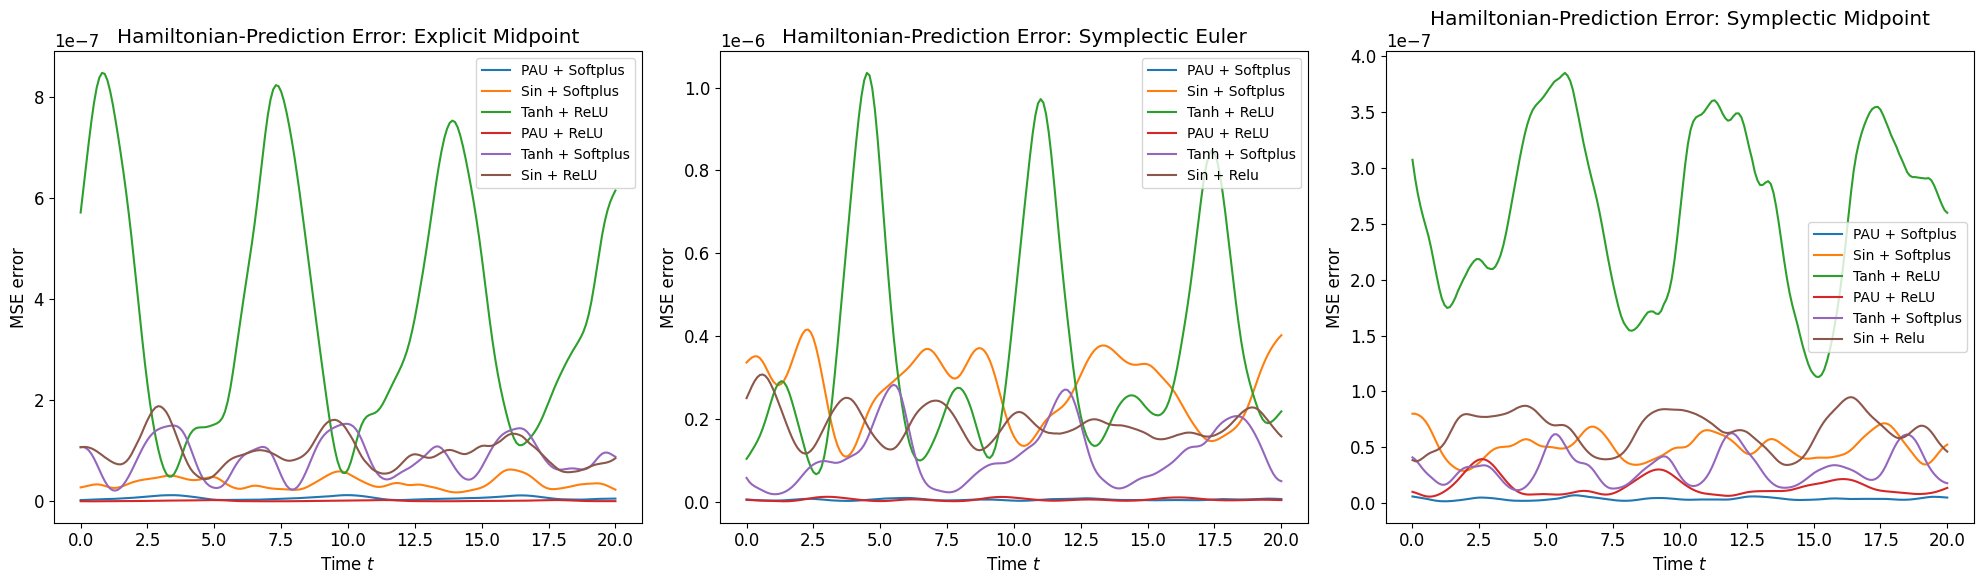

In [86]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))


ax[0].plot(t_test, H_err_exp_PAU_Soft, label="PAU + Softplus")
ax[0].plot(t_test, H_err_exp_Sin_Soft, label="Sin + Softplus")
ax[0].plot(t_test, H_err_exp_Tanh_ReLU, label="Tanh + ReLU")
ax[0].plot(t_test, H_err_exp_PAU_ReLU, label="PAU + ReLU")
ax[0].plot(t_test, H_err_exp_Tanh_soft, label="Tanh + Softplus")
ax[0].plot(t_test, H_err_exp_Sin_ReLU, label="Sin + ReLU")
ax[0].set_xlabel(f"Time $t$")
ax[0].set_ylabel("MSE error")
ax[0].set_title("Hamiltonian-Prediction Error: Explicit Midpoint")
ax[0].legend()


ax[1].plot(t_test, H_err_symp_eul_PAU_Soft, label="PAU + Softplus")
ax[1].plot(t_test, H_err_symp_eul_Sin_Soft, label="Sin + Softplus")
ax[1].plot(t_test, H_err_symp_eul_Tanh_ReLU, label="Tanh + ReLU")
ax[1].plot(t_test, H_err_symp_eul_PAU_ReLU, label="PAU + ReLU")
ax[1].plot(t_test, H_err_symp_eul_Tanh_soft, label="Tanh + Softplus")
ax[1].plot(t_test, H_err_symp_eul_Sin_ReLU, label="Sin + Relu")
ax[1].set_xlabel(f"Time $t$")
ax[1].set_ylabel("MSE error")
ax[1].set_title("Hamiltonian-Prediction Error: Symplectic Euler")
ax[1].legend()


ax[2].plot(t_test, H_err_symp_PAU_Soft, label="PAU + Softplus")
ax[2].plot(t_test, H_err_symp_Sin_Soft, label="Sin + Softplus")
ax[2].plot(t_test, H_err_symp_Tanh_ReLU, label="Tanh + ReLU")
ax[2].plot(t_test, H_err_symp_PAU_ReLU, label="PAU + ReLU")
ax[2].plot(t_test, H_err_symp_Tanh_soft, label="Tanh + Softplus")
ax[2].plot(t_test, H_err_symp_Sin_ReLU, label="Sin + Relu")
ax[2].set_xlabel(f"Time $t$")
ax[2].set_ylabel("MSE error")
ax[2].set_title("Hamiltonian-Prediction Error: Symplectic Midpoint")
ax[2].legend()
 


plt.tight_layout() 
plt.show()

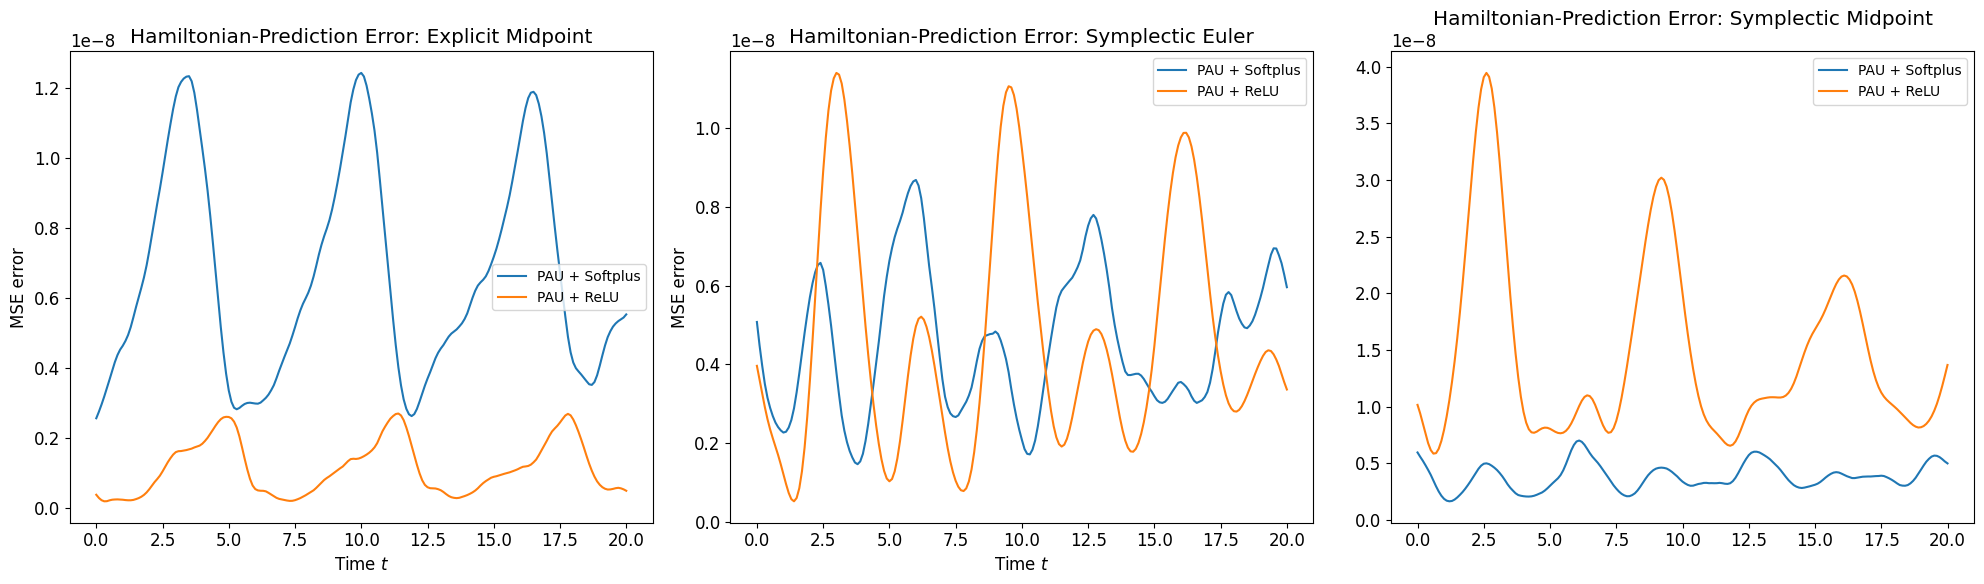

In [87]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))




ax[0].plot(t_test, H_err_exp_PAU_Soft, label="PAU + Softplus")
ax[0].plot(t_test, H_err_exp_PAU_ReLU, label="PAU + ReLU")
ax[0].set_xlabel(f"Time $t$")
ax[0].set_ylabel("MSE error")
ax[0].set_title("Hamiltonian-Prediction Error: Explicit Midpoint")
ax[0].legend()



ax[1].plot(t_test, H_err_symp_eul_PAU_Soft, label="PAU + Softplus")
ax[1].plot(t_test, H_err_symp_eul_PAU_ReLU, label="PAU + ReLU")
ax[1].set_xlabel(f"Time $t$")
ax[1].set_ylabel("MSE error")
ax[1].set_title("Hamiltonian-Prediction Error: Symplectic Euler")
ax[1].legend()



ax[2].plot(t_test, H_err_symp_PAU_Soft, label="PAU + Softplus")
ax[2].plot(t_test, H_err_symp_PAU_ReLU, label="PAU + ReLU")
ax[1].set_xlabel(f"Time $t$")
ax[1].set_ylabel("MSE error")
ax[2].set_title("Hamiltonian-Prediction Error: Symplectic Midpoint")
ax[2].legend()


plt.tight_layout() 
plt.show()